In [522]:
from urllib.request import urlopen
import datetime
from datetime import timedelta
import csv
import pandas as pd
from scipy import signal
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import numpy as np
import holidays
from datetime import timedelta
import math
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import os

In [523]:
#list the model files for all markets/vendors

os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Model_Files')
sunday_markets=['SUN_AG_AWS.pkl','SUN_Hot Food_AWS.pkl','SUN_Retail_AWS.pkl','SUN_Coffee_AWS.pkl','SUN_Baked Goods_AWS.pkl']
wednesday_markets=['WED_AG_AWS.pkl']
saturday_markets=['SAT_AG_AWS.pkl']
pico_markets=['PICO_AG_AWS.pkl','PICO_Hot Food_AWS.pkl','PICO_Coffee_AWS.pkl','PICO_Baked Goods_AWS.pkl']


ag_vendors=['SUN_AG_AWS.pkl','SAT_AG_AWS.pkl','WED_AG_AWS.pkl','PICO_AG_AWS.pkl']
coffee_vendors=['SUN_Coffee_AWS.pkl','PICO_Coffee_AWS.pkl']
hf_vendors=['SUN_Hot Food_AWS.pkl','PICO_Hot Food_AWS.pkl']
baked_good_vendors=['SUN_Baked Goods_AWS.pkl','PICO_Baked Goods_AWS.pkl']
retail_vendors=['SUN_Retail_AWS.pkl','PICO_Baked Goods_AWS.pkl']

In [524]:
model_files=ag_vendors+hf_vendors

In [525]:
#calculate the map for all baselines as well as model

model_mapes=[]
baseline_mapes=[]
naive_baseline_mapes=[]
persistance_mapes=[]

for file in model_files:
    
    temporary_df=pd.read_pickle(file)
    actual_sales=np.array(temporary_df.iloc[0]['actual sales'])
    mean_sales=np.mean(actual_sales)
    test_set_sales=actual_sales[-50:]
    persistance_baseline=np.array(actual_sales[-51:-1])
    naive_baseline=np.array([mean_sales]*len(test_set_sales))
    
    persistance_mapes.append(np.mean(abs(persistance_baseline-test_set_sales)/test_set_sales))
    naive_baseline_mapes.append(np.mean(abs(naive_baseline-test_set_sales)/test_set_sales))
    model_mapes.append(temporary_df.iloc[0]['ridge mape'])
    baseline_mapes.append(temporary_df.iloc[0]['baseline mape'])

In [526]:
# display average map for the various models/baseline

np.mean(model_mapes)

0.10888215313660327

In [527]:
np.mean(baseline_mapes)

0.13176989645300727

In [528]:
np.mean(naive_baseline_mapes)

0.1992824329328057

In [529]:
np.mean(persistance_mapes)

0.162890355187733

In [530]:
#detect "anomalous" market events where sales change by over 30% week to week 
#and calculate mape for these events


anom_model_trigs=[]
anom_baseline_trigs=[]
anom_naive_baseline_trigs=[]
anom_persistance_trigs=[]

anom_values=[]

anom_model_mapes=[]
anom_baseline_mapes=[]
anom_naive_baseline_mapes=[]
anom_persistance_mapes=[]

num_anoms=0

for file in model_files:
    
    temporary_df=pd.read_pickle(file)
    actual_sales=np.array(temporary_df.iloc[0]['actual sales'])
    mean_sales=np.mean(actual_sales)
    
    test_set_sales=actual_sales[-50:]
    naive_baseline=np.array([mean_sales]*len(test_set_sales))
    persistance_predicts=np.array(actual_sales[-51:-1])
    
    model_predicts=temporary_df.iloc[0]['model predictions'][-50:]
    baseline_predicts=temporary_df.iloc[0]['baseline predictions'][-50:]
    
    master_list=list(zip(test_set_sales,naive_baseline,model_predicts,baseline_predicts,persistance_predicts))
    
    percent_change=.25
    anoms=[master_list[i] for i in range(1,len(master_list)) if abs(master_list[i-1][0]-master_list[i][0])/master_list[i-1][0]>percent_change]
    anom_value=[abs(master_list[i][0]-master_list[i-1][0])/master_list[i][0] for i in range(1,len(master_list)) if abs(master_list[i-1][0]-master_list[i][0])/master_list[i-1][0]>percent_change]
    anom_values.append(anom_value)
    print("Number of anomalies: {}".format(len(anoms)))
    
    for anom in anoms:
        num_anoms+=1
        if abs(anom[0]-anom[1])/anom[0]<.15:
            anom_naive_baseline_trigs.append(1)
        if abs(anom[0]-anom[2])/anom[0]<.15:
            anom_model_trigs.append(1)
        if abs(anom[0]-anom[3])/anom[0]<.15:
            anom_baseline_trigs.append(1)
        if abs(anom[0]-anom[4])/anom[0]<.15:
            anom_persistance_trigs.append(1)
        
        
        anom_baseline_mapes.append(abs(anom[0]-anom[3])/anom[0])
        anom_model_mapes.append(abs(anom[0]-anom[2])/anom[0])
        anom_naive_baseline_mapes.append(abs(anom[0]-anom[1])/anom[0])
        anom_persistance_mapes.append(abs(anom[0]-anom[4])/anom[0])
        

Number of anomalies: 4
Number of anomalies: 2
Number of anomalies: 5
Number of anomalies: 9
Number of anomalies: 20
Number of anomalies: 9


In [531]:
print('Average anomlous event sales change: {}'.format(np.mean([i for sublist in anom_values for i in sublist])))
print("Anom MAPE model: {}".format(np.mean(anom_model_mapes)))
print("Anom MAPE baseline: {}".format(np.mean(anom_baseline_mapes)))
print("Anom MAPE naive: {}".format(np.mean(anom_naive_baseline_mapes)))
print("Anom MAPE persistance: {}".format(np.mean(anom_persistance_mapes)))

Average anomlous event sales change: 0.5631413111068476
Anom MAPE model: 0.2806468128942637
Anom MAPE baseline: 0.3307684053742342
Anom MAPE naive: 0.3945517903058421
Anom MAPE persistance: 0.5631413111068476


In [532]:
print("Model Anomaly Detection: {}".format(np.sum(anom_model_trigs)/num_anoms))
print("Baseline Anomaly Detection: {}".format(np.sum(anom_baseline_trigs)/num_anoms))
print("Naive Baseline Anomaly Detection: {}".format(np.sum(anom_naive_baseline_trigs)/num_anoms))
print("Persistance Baseline Anomaly Detection: {}".format(np.sum(anom_persistance_trigs)/num_anoms))

Model Anomaly Detection: 0.40816326530612246
Baseline Anomaly Detection: 0.3469387755102041
Naive Baseline Anomaly Detection: 0.3673469387755102
Persistance Baseline Anomaly Detection: 0.0


In [533]:
sample_files=pd.read_pickle(sunday_markets[0])

Text(0.5, 1.0, 'Sunday downtown market')

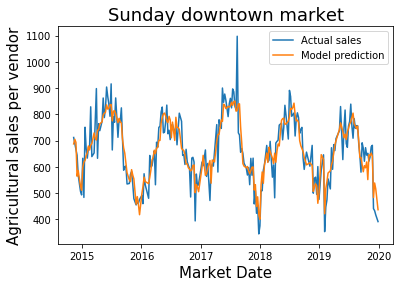

In [534]:
#make some plots to compare model to actual sales 

plt.figure()
plt.plot(sample_files.iloc[0]['dates'],sample_files.iloc[0]['actual sales'],label='Actual sales')
plt.plot(sample_files.iloc[0]['dates'],sample_files.iloc[0]['model predictions'],label='Model prediction')

plt.xlabel('Market Date',fontsize=15)
plt.ylabel('Agricultural sales per vendor',fontsize=15)
plt.legend()
plt.title('Sunday downtown market',fontsize=18)
#plt.savefig('model_sales.png',dpi=600)

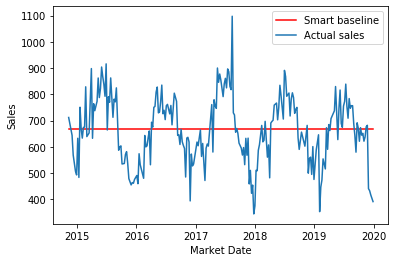

In [535]:
#compare naive baseline to actual sales

plt.figure()
plt.plot(sample_files.iloc[0]['dates'],[np.mean(sample_files.iloc[0]['actual sales'])]*len(sample_files.iloc[0]['actual sales']),label='Smart baseline',color='red')
plt.plot(sample_files.iloc[0]['dates'],sample_files.iloc[0]['actual sales'],label='Actual sales')
plt.xlabel('Market Date')
plt.ylabel('Sales')
plt.legend()
#plt.savefig('average_baseline.png')

In [536]:
#now I want to analyze the rankings of the feature coefficient strengths across my models

In [537]:
#import coefficients from model pkl files

os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Model_Files')

d = pd.DataFrame()

for i,filename in enumerate(model_files):
    temporary_df=pd.read_pickle(filename)
    
    coeff_vals=list(temporary_df.iloc[0]['ridge model'].coef_)
    feature_names=list(temporary_df.iloc[0]['feature matrix'].columns)
    
    day_index=filename.index('_')
    day_name=filename[:day_index]
    
    product_index=filename[day_index+1:].index('_')
    product_name=filename[day_index+1:product_index+day_index+1]
    
    df_market=pd.DataFrame([coeff_vals+[day_name,product_name]],columns=feature_names+['market day','product type'], index=[i])
    d=d.append(df_market)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


<Figure size 432x288 with 0 Axes>

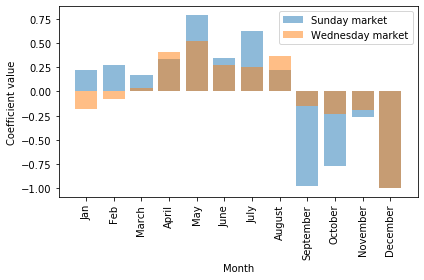

In [538]:
#i want to make a plot comparing two differnet ag vendor model and their coefficients
os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Plots\\Features')
plt.figure()
months=['Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']
files_cat=['Sunday market','Wednesday market']
plt.figure()
for index,i in enumerate([0,2]):
    month_vals=[]

    for month in months:
        month_vals.append(d.loc[i][month])
    plt.bar([i[3:] for i in months],month_vals/max(abs(np.array(month_vals))),label=files_cat[index],alpha=.5)
    plt.xticks(rotation=90)
    plt.xlabel('Month')
    plt.ylabel('Coefficient value')
plt.legend()
plt.tight_layout()
plt.savefig('monthly_breakdown.png',dpi=500)

In [539]:
#this will normalize the coefficients so they can be compared  across products (cash flow is different so coefficients are
#on different scales)

d_norm=d.copy()
for i in range(len(model_files)):
    data=np.array(list(d_norm.loc[i])[:-2])
    d_norm.loc[i]=list(data/max(abs(data)))+list(d.loc[i][-2:])

In [540]:
#let's compare hot food and ag vendors

farm_grouped=d_norm.groupby('product type').mean().loc['AG'].sort_values()
hf_grouped=d_norm.groupby('product type').mean().loc['Hot Food'].sort_values()

In [544]:
#select which features to compare and plot

features_to_compare=['Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December','Rain','Temperature','Wind','Previous Markets','Christmas','Thanksgiving','NYE','Memorial Day','July Fourth']

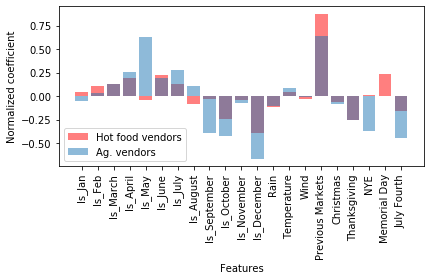

In [545]:
#now plot coefficients

plt.figure()
plt.bar(features_to_compare,list(hf_grouped[features_to_compare]),label='Hot food vendors',alpha=.5,color='r')
plt.bar(features_to_compare,list(farm_grouped[features_to_compare]),label='Ag. vendors',alpha=.5)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Normalized coefficient')
plt.legend()
plt.tight_layout()

plt.savefig('ag_vs_hot.png',dpi=500)